In [2]:
# import and set options
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import sklearn
from sklearn.metrics import roc_curve, auc
import utils
mpl.rcParams['pdf.fonttype'] = 42

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## ATM

Explanation of ATM to come.

### Prepare data

#### TCGA mutations

First read the score results for all TCGA mutations.

In [3]:
pancan_df = utils.read_result('PANCAN')

Then read the results for ATM.

In [4]:
signif_mc3_atm_df, all_mc3_atm_df = utils.read_atm_result('data/aggregated_results/PANCAN.txt', 'data/aggregated_results/PANCAN.maf')

In [5]:
cols_of_interest = ['Tumor_Sample_Barcode', 'CODE', 'HGVSp_Short', 'recurrence', 
                    'CHASM2_genome', 'CHASM2_genome_pval', 'CHASM2_genome_qval', 'Protein_position',
                    'Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']
all_mc3_atm_df = all_mc3_atm_df[cols_of_interest]

#### MSK-IMPACT mutations

In [6]:
signif_msk_atm_df, all_msk_atm_df = utils.read_atm_result('data/gene_panel/msk_impact.txt', 'data/gene_panel/msk_impact.maf')

In [7]:
cols_of_interest = ['Tumor_Sample_Barcode', 'HGVSp_Short', 'recurrence','CHASM2_genome', 'CHASM2_genome_pval', 'CHASM2_genome_qval',
                    'Protein_position', 'Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']
all_msk_atm_df = all_msk_atm_df[cols_of_interest]

#### Merge MSK/MC3

In [8]:
# merge the mutations
signif_msk_atm_df['Significant MSK-IMPACT (CHASM2)'] = 'yes'
signif_mc3_atm_df['Significant TCGA (CHASM2)'] = 'yes'
signif_df = pd.merge(signif_mc3_atm_df, signif_msk_atm_df, 
                     on=['Hugo_Symbol', 'HGVSp_Short'], 
                     how='outer', suffixes=['', '_msk'])
rename_dict = {'recurrence': 'TCGA samples', 'recurrence_msk': 'MSK-IMPACT samples'}
signif_df = signif_df.rename(columns=rename_dict)

# format columns
signif_df['Significant TCGA (CHASM2)'] = signif_df['Significant TCGA (CHASM2)'].fillna('no') 
signif_df['Significant MSK-IMPACT (CHASM2)'] = signif_df['Significant MSK-IMPACT (CHASM2)'].fillna('no')
signif_df['TCGA samples'] = signif_df['TCGA samples'].fillna(0).astype(int)
signif_df['MSK-IMPACT samples'] = signif_df['MSK-IMPACT samples'].fillna(0).astype(int)

# figure out protein position
signif_df['Protein_position'] = signif_df['HGVSp_Short'].str.extract('^p.[A-Z]([0-9]+)[A-Z]$', expand=False)

# Overlap on the codon-level
signif_df['Study overlap (residue-level)'] = 'no'
tcga_pos_list = signif_df[signif_df['Significant TCGA (CHASM2)']=='yes']['Protein_position'].tolist()
msk_pos_list = signif_df[signif_df['Significant MSK-IMPACT (CHASM2)']=='yes']['Protein_position'].tolist()
overlap = set(tcga_pos_list) & set(msk_pos_list)
signif_df.loc[(signif_df['Protein_position'].isin(overlap)), 'Study overlap (residue-level)'] = 'yes'

In [9]:
cols_of_interest = ['HGVSp_Short', 'Protein_position', 'TCGA samples', 'MSK-IMPACT samples', 
                    'Significant TCGA (CHASM2)', 'Significant MSK-IMPACT (CHASM2)', 'Study overlap (residue-level)']
signif_df[cols_of_interest].to_clipboard(index=False)

### Examine distribution of gwCHASM2 scores

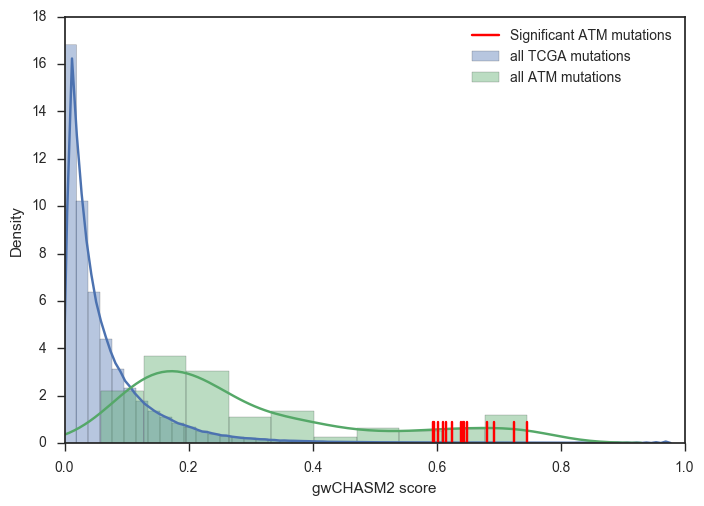

In [10]:
with sns.axes_style('ticks'):
    sns.distplot(pancan_df['CHASM2_genome'].dropna(), label='all TCGA mutations')
    sns.distplot(all_mc3_atm_df['CHASM2_genome'].dropna(), label='all ATM mutations')
    plt.xlim((0,1))
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    
    label = 'Significant ATM mutations'
    atm_scores = signif_mc3_atm_df['CHASM2_genome'].unique()
    for s in atm_scores:     
        plt.axvline(s, color='red', ymax=.05, label=label)
        label=''
    
    plt.ylabel('Density')
    plt.xlabel('gwCHASM2 score')
    plt.legend(loc='best')

### Select ATM mutations for testing

First copy all of the mutations found in TGCA or the MSK-IMPACT gene panel to excel.

In [40]:
all_msk_atm_df.to_clipboard()

In [41]:
all_mc3_atm_df.to_clipboard()

Next, prepare a dataframe to randomly sample low scoring ATM mutations.

In [86]:
reduced_cols = ['HGVSp_Short', 'Protein_position', 'CHASM2_genome', 'CHASM2_genome_pval', 'CHASM2_genome_qval',
                'Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']
full_df = pd.concat([all_mc3_atm_df[reduced_cols], all_msk_atm_df[reduced_cols]])
full_df = full_df[full_df['CHASM2_genome_pval']>0.05].drop_duplicates(['HGVSp_Short'])
full_df['domain'] = 'non-kinase'
full_df.loc[full_df['Protein_position'].astype(int)>2612, 'domain'] = 'kinase'

Randomly pick two mutations from the kinase domain.

In [90]:
prng = np.random.RandomState(101)
full_df[full_df['domain']=='kinase'].sample(2, random_state=prng)

,HGVSp_Short,Protein_position,CHASM2_genome,CHASM2_genome_pval,CHASM2_genome_qval,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,domain
7756,p.M2667L,2667,0.172854,0.453642,0.762152,11,108204684,108204684,A,T,kinase
753,p.L2965F,2965,0.249480,0.264539,0.610802,11,108235853,108235853,G,T,kinase


Randomly pick two mutations from anywhere besides the kinase domain.

In [88]:
full_df[full_df['domain']=='non-kinase'].sample(2, random_state=prng)

,HGVSp_Short,Protein_position,CHASM2_genome,CHASM2_genome_pval,CHASM2_genome_qval,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,domain
72094,p.L1420F,1420,0.110484,0.664918,0.876384,11,108160350,108160350,C,T,non-kinase
41214,p.L1348W,1348,0.295812,0.181422,0.518030,11,108158376,108158376,T,G,non-kinase


In [69]:
','.join([str(t)+'.A' for t in set(msk_impact_atm) & set(mc3_atm)])

NameError: name 'msk_impact_atm' is not defined